<h1>Test</h1>
- 병렬노드 테스트
- 참조 소스코드 : https://velog.io/@euisuk-chung/LangChain-Academy-Introduction-to-LangGraph-Module-4

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

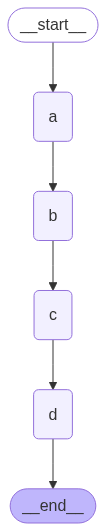

In [3]:
class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"{self._value}를 {state['state']}에 추가합니다")
        return {"state": [self._value]}

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"state": ""})

나는 A입니다를 에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다
나는 C입니다를 ['나는 B입니다']에 추가합니다
나는 D입니다를 ['나는 C입니다']에 추가합니다


{'state': ['나는 D입니다']}

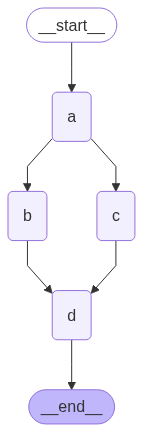

In [5]:
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# 구조는 위와 같이 쉽게 정의할 수 있지만, 막상 실행해보면, B와 C가 동시에 동일한 상태 키를 업데이트하려 하므로 충돌이 발생하여 에러가 발생하게 됩니다.
graph.invoke({"state": ""})

나는 A입니다를 에 추가합니다
나는 C입니다를 ['나는 A입니다']에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다


InvalidUpdateError: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

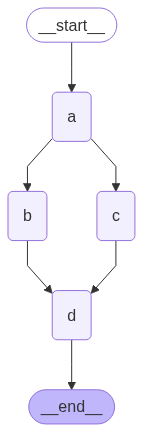

In [7]:
# 병렬 노드 B와 C가 동시에 리스트에 값을 추가하도록 리듀서를 사용하여 상태 충돌을 해결합니다.
# 팬 아웃을 사용할 때는 단계가 동일한 채널/키에 쓰는 경우 리듀서를 사용해야 합니다.
# 모듈 2에서 언급했듯이 operator.add는 Python의 내장 operator 모듈의 함수입니다.
# operator.add가 리스트에 적용되면 리스트 연결을 수행합니다.
import operator
from typing import Annotated

class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: Annotated[list, operator.add]

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
graph.invoke({"state": []})


나는 A입니다를 []에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다
나는 C입니다를 ['나는 A입니다']에 추가합니다
나는 D입니다를 ['나는 A입니다', '나는 B입니다', '나는 C입니다']에 추가합니다


{'state': ['나는 A입니다', '나는 B입니다', '나는 C입니다', '나는 D입니다']}

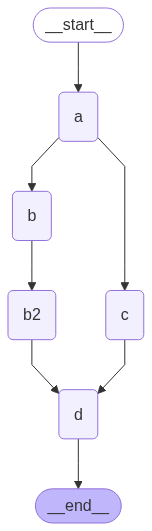

In [9]:
class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"state": []})

I'm A를 []에 추가합니다
I'm B를 ["I'm A"]에 추가합니다
I'm C를 ["I'm A"]에 추가합니다
I'm B2를 ["I'm A", "I'm B", "I'm C"]에 추가합니다
I'm D를 ["I'm A", "I'm B", "I'm C", "I'm B2"]에 추가합니다


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

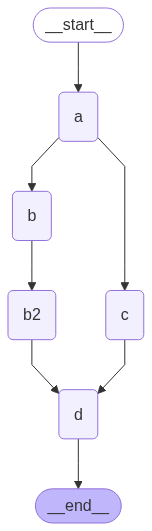

In [14]:
def sorting_reducer(left, right):
    """ 리스트의 값들을 결합하고 정렬합니다"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer는 상태의 값들을 정렬합니다
    state: Annotated[list, sorting_reducer]

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("b2", ReturnNodeValue("나는 B2입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



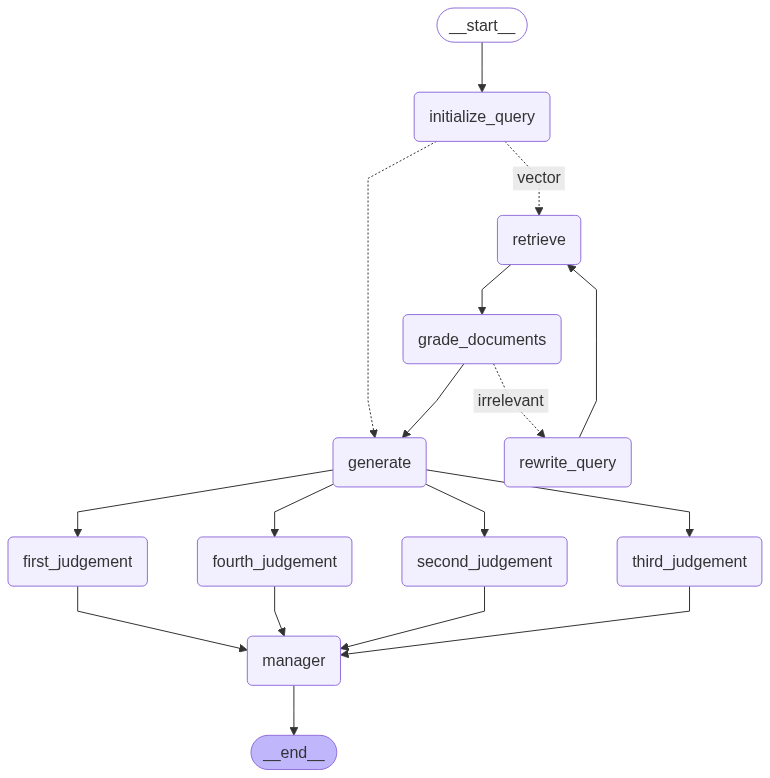

In [17]:
from typing import TypedDict, Annotated, List, Optional, Dict, Any
from langchain.schema import HumanMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display
from langgraph.graph.message import add_messages

import logging

logger = logging.getLogger(__name__)


class ManagingState(TypedDict):
    question: str
    chat_history: Annotated[List[BaseMessage], add_messages]
    retrieved_docs: Optional[List[str]]
    rewritten_question: Optional[str]
    rewrite_count: int
    answer: Optional[str]
    evaluation_results: Optional[Dict[str, str]]
    final_decision: Optional[str]
    logs: Optional[List[Dict[str, Any]]]
    error: Optional[Dict[str, str]]
    metadata: Optional[Dict[str, Any]]
    summary: Optional[str]

def initialize_query(state: ManagingState):
    '''입력받은 질문을 기존 이력 여부에 따라 변형하는 노드'''
    logger.info('======== [NODE] INITIALIZE_QUERY ========')
    
    return ''

def retrieve(state: ManagingState):
    '''질문을 기반으로 Retriever 검색을 수행하는 노드'''
    logger.info('======== [NODE] RETRIEVE ========')
    
    return ''

def grade_documents(state: ManagingState):
    '''검색된 문서의 관련성을 평가하는 노드'''
    logger.info('======== [NODE] GRADE_DOCUMENTS ========')
    
    return ''

def rewrite_query(state: ManagingState):
    '''질문을 의미 기반으로 재작성하는 노드'''
    logger.info('======== [NODE] REWRITE_QUERY ========')
    
    return ''

def generate(state: ManagingState):
    '''컨텍스트를 기반으로 답변을 생성하는 노드'''
    logger.info('======== [NODE] GENERATE ========')
    
    return ''

def first_judgement(state: ManagingState):
    '''생성된 답변을 판단하는 첫번째 노드'''
    logger.info('======== [NODE] FIRST_JUDGEMENT ========')
    
    return ''

def second_judgement(state: ManagingState):
    '''생성된 답변을 판단하는 두번째 노드'''
    logger.info('======== [NODE] SECOND_JUDGEMENT ========')
    
    return ''

def third_judgement(state: ManagingState):
    '''생성된 답변을 판단하는 세번째 노드'''
    logger.info('======== [NODE] THIRD_JUDGEMENT ========')
    
    return ''

def fourth_judgement(state: ManagingState):
    '''생성된 답변을 판단하는 네번째 노드'''
    logger.info('======== [NODE] FOURTH_JUDGEMENT ========')
    
    return ''

def manager(state: ManagingState):
    '''답변을 취합하는 노드'''
    logger.info('======== [NODE] MANAGER ========')
    
    return ''

def route_vector_or_generate():
    ''

def route_generate_by_relevance():
    ''

workflow = StateGraph(ManagingState)

workflow.add_node("initialize_query", initialize_query)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate", generate)
workflow.add_node("first_judgement", first_judgement)
workflow.add_node("second_judgement", second_judgement)
workflow.add_node("third_judgement", third_judgement)
workflow.add_node("fourth_judgement", fourth_judgement)
workflow.add_node("manager", manager)

workflow.add_edge(START, "initialize_query")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate", "first_judgement")
workflow.add_edge("generate", "second_judgement")
workflow.add_edge("generate", "third_judgement")
workflow.add_edge("generate", "fourth_judgement")
workflow.add_edge("first_judgement", "manager")
workflow.add_edge("second_judgement", "manager")
workflow.add_edge("third_judgement", "manager")
workflow.add_edge("fourth_judgement", "manager")
workflow.add_edge("manager", END)

workflow.add_conditional_edges(
    "initialize_query",
    route_vector_or_generate,
    {
        "vector": "retrieve",
        "generate": "generate"
    }
)
workflow.add_conditional_edges(
    "grade_documents",
    route_generate_by_relevance,
    {
        "relevant": "generate",
        "irrelevant": "rewrite_query"
    }
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

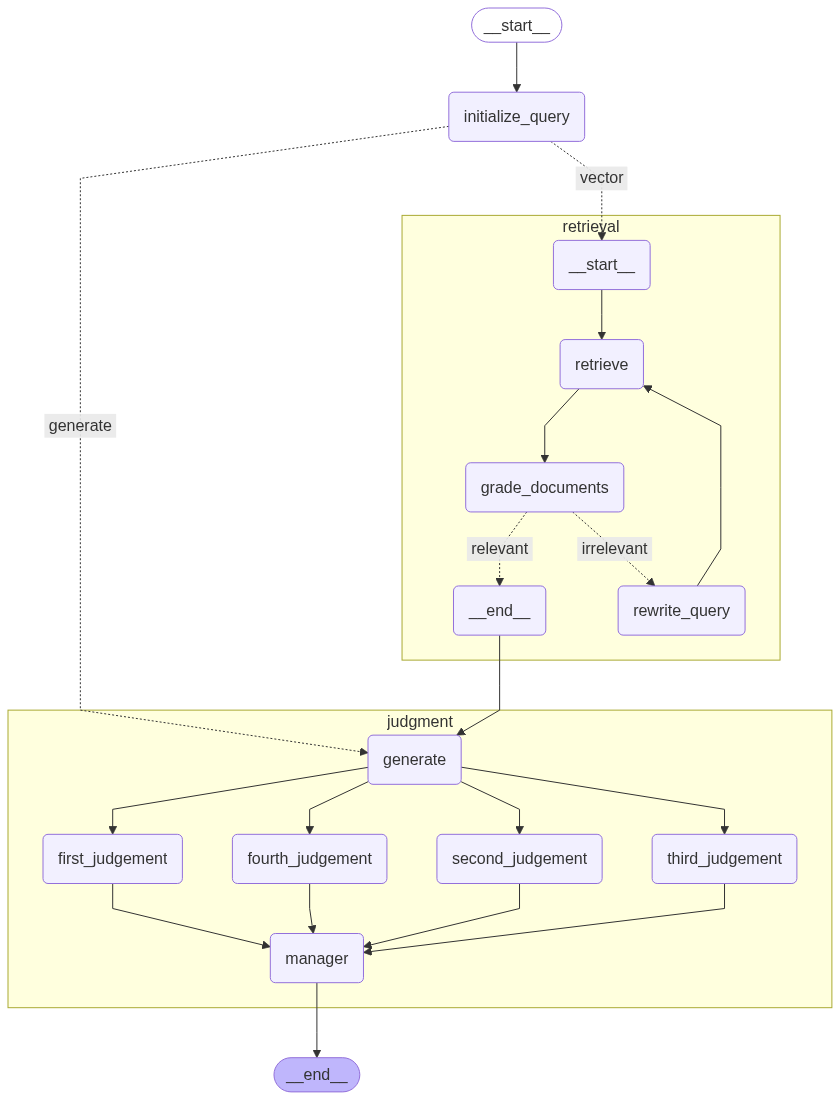

In [35]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# Subgraph 1: Retrieval and Grading
retrieval_graph = StateGraph(ManagingState)
retrieval_graph.add_node("retrieve", retrieve)
retrieval_graph.add_node("grade_documents", grade_documents)
retrieval_graph.add_node("rewrite_query", rewrite_query)
retrieval_graph.add_edge(START, "retrieve")
retrieval_graph.add_edge("retrieve", "grade_documents")
retrieval_graph.add_edge("rewrite_query", "retrieve")
retrieval_graph.add_conditional_edges(
    "grade_documents",
    route_generate_by_relevance,
    {"relevant": END, "irrelevant": "rewrite_query"}
)

# Subgraph 2: Generation and Judgment
judgment_graph = StateGraph(ManagingState)
judgment_graph.add_node("generate", generate)
judgment_graph.add_node("first_judgement", first_judgement)
judgment_graph.add_node("second_judgement", second_judgement)
judgment_graph.add_node("third_judgement", third_judgement)
judgment_graph.add_node("fourth_judgement", fourth_judgement)
judgment_graph.add_node("manager", manager)
judgment_graph.add_edge(START, "generate")  # START에서 generate로 연결
judgment_graph.add_edge("generate", "first_judgement")
judgment_graph.add_edge("generate", "second_judgement")
judgment_graph.add_edge("generate", "third_judgement")
judgment_graph.add_edge("generate", "fourth_judgement")
judgment_graph.add_edge("first_judgement", "manager")
judgment_graph.add_edge("second_judgement", "manager")
judgment_graph.add_edge("third_judgement", "manager")
judgment_graph.add_edge("fourth_judgement", "manager")
judgment_graph.add_edge("manager", END)

# 메인 그래프
main_workflow = StateGraph(ManagingState)
main_workflow.add_node("initialize_query", initialize_query)  # 초기화 노드 추가
main_workflow.add_node("retrieval", retrieval_graph.compile())

main_workflow.add_node("judgment", judgment_graph.compile())

# 메인 그래프 엣지
main_workflow.add_edge(START, "initialize_query")
main_workflow.add_conditional_edges(
    "initialize_query",
    route_vector_or_generate,
    {"vector": "retrieval", "generate": "judgment"}
)
main_workflow.add_edge("retrieval", "judgment")
main_workflow.add_edge("judgment", END)

# 컴파일 및 시각화
graph = main_workflow.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

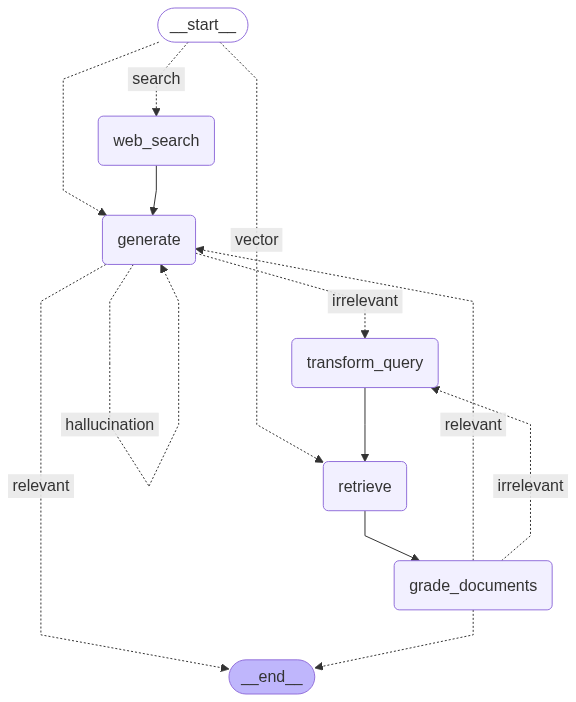

In [41]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # utils가 상위 폴더에 있을 경우
from graph.workflow import build_workflow


graph = build_workflow('')
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

<h1>PostgreSaver</h1>

In [ ]:
# Jupyter Notebook: PostgreSaver 테스트
import psycopg
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.postgres import PostgresSaver
from typing import TypedDict, Annotated
import operator
import os
from dotenv import load_dotenv

# 0. 환경 변수 로드
load_dotenv()

# 1. 상태 스키마 정의
class State(TypedDict):
    input: str
    output: str

# 2. 노드 정의
def process_input(state: State) -> State:
    return {"input": state["input"], "output": f"Processed: {state['input']}"}

# 3. 워크플로우 설정
workflow = StateGraph(State)
workflow.add_node("process", process_input)
workflow.add_edge("process", END)
workflow.set_entry_point("process")

# 4. PostgreSaver 설정
try:
    conn = psycopg.connect(
        dbname=os.getenv("POSTGRE_NAME"),
        user=os.getenv("POSTGRE_USER"),
        password=os.getenv("POSTGRE_PASSWORD"),
        host=os.getenv("POSTGRE_HOST"),
        port=os.getenv("POSTGRE_PORT")
    )
    print("PostgreSQL connection successful")
except Exception as e:
    print(f"Connection failed: {e}")
    raise

# PostgresSaver 초기화 및 테이블 설정
try:
    # 오토커밋 모드 활성화
    # 오토커밋 모드를 활성화해 CREATE INDEX CONCURRENTLY가 트랜잭션 없이 실행되도록 함.
    conn.autocommit = True
    checkpointer = PostgresSaver(conn)
    checkpointer.setup()  # 테이블 및 인덱스 생성
    print("Tables created successfully")
    
    # 테이블 생성 확인
    with conn.cursor() as cur:
        cur.execute("SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'checkpoints')")
        exists = cur.fetchone()[0]
        print(f"Table 'checkpoints' exists: {exists}")
except Exception as e:
    print(f"Table creation failed: {e}")
    conn.close()
    raise

# 5. 워크플로우 컴파일
app = workflow.compile(checkpointer=checkpointer)

# 6. 테스트 실행
input_state = {"input": "Hello, PostgreSaver!"}
result = app.invoke(input_state, config={"configurable": {"thread_id": "test-thread-1"}})

print("Result:", result)

# 7. 저장된 상태 확인
saved_state = checkpointer.get({"configurable": {"thread_id": "test-thread-1"}})
print("Saved State:", saved_state)

# 8. 연결 종료
conn.close()

PostgreSQL connection successful
Tables created successfully
Table 'checkpoints' exists: True
Result: {'input': 'Hello, PostgreSaver!', 'output': 'Processed: Hello, PostgreSaver!'}
Saved State: {'v': 3, 'id': '1f045cfc-fbec-604a-8001-faf7e43eac8b', 'ts': '2025-06-10T07:52:09.441692+00:00', 'pending_sends': [], 'versions_seen': {'process': {'branch:to:process': '00000000000000000000000000000002.0.7362419887058252'}, '__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.8898375004104155'}}, 'channel_versions': {'input': '00000000000000000000000000000003.0.16207263748873146', 'output': '00000000000000000000000000000003.0.2615641269416915', '__start__': '00000000000000000000000000000002.0.5535911814791319', 'branch:to:process': '00000000000000000000000000000003.0.5515336825437215'}, 'channel_values': {'input': 'Hello, PostgreSaver!', 'output': 'Processed: Hello, PostgreSaver!'}}


In [ ]:
# 다음 테이블이 만들어짐.
# mydb=# \d
#                       List of relations
#  Schema |             Name             |   Type   |  Owner   
# --------+------------------------------+----------+----------
#  public | checkpoint_blobs             | table    | postgres
#  public | checkpoint_migrations        | table    | postgres
#  public | checkpoint_writes            | table    | postgres
#  public | checkpoints                  | table    | postgres

In [ ]:
''' checkpoints

field : thread_id   | checkpoint_ns | checkpoint_id   |  parent_checkpoint_id   | type |  checkpoint |   metadata

test-thread-1 |               | 1f045cfc-fbe7-6932-bfff-a31a9b9996ac |                                      |      | {"v": 3, "id": "1f045cfc-fbe7-6932-bfff-a31a9b9996ac", "ts": "2025-06-10T07:52:09.439866+00:00", "pending_sends": [], "versions_seen": {"__input__": {}}, "channel_versions": {"__start__": "00000000000000000000000000000001.0.8898375004104155"}}   


• v: 체크포인트 버전 (3).
• id: 체크포인트의 고유 ID.
• ts: 타임스탬프 (상태 저장 시각).
• channel_values: 워크플로우의 입력(input)과 출력(output) 상태.
• channel_versions, versions_seen: 상태와 노드 간의 버전 관리 정보.
• pending_sends: 비동기 작업 대기열 (현재는 비어 있음).
'''

In [ ]:
'''
mydb=# select * from checkpoint_writes;

   thread_id   | checkpoint_ns |            checkpoint_id             |               task_id                | idx |      channel      |  type   |                                blob                                |         task_path         

   
 test-thread-1 |               | 1f045cfc-fbe7-6932-bfff-a31a9b9996ac | 88800470-e6ca-17e1-0ddc-7dd18283c0bc |   0 | input             | msgpack | \xb448656c6c6f2c20506f7374677265536176657221                       | ~__pregel_pull, __start__
 test-thread-1 |               | 1f045cfc-fbe7-6932-bfff-a31a9b9996ac | 88800470-e6ca-17e1-0ddc-7dd18283c0bc |   1 | branch:to:process | null    | \x                                                                 | ~__pregel_pull, __start__
 test-thread-1 |               | 1f045cfc-fbe9-617e-8000-0bf404c30aec | 9894fd19-6790-0949-0f02-4b6910ff2ce2 |   0 | input             | msgpack | \xb448656c6c6f2c20506f7374677265536176657221                       | ~__pregel_pull, process
 test-thread-1 |               | 1f045cfc-fbe9-617e-8000-0bf404c30aec | 9894fd19-6790-0949-0f02-4b6910ff2ce2 |   1 | output            | msgpack | \xbf50726f6365737365643a2048656c6c6f2c20506f7374677265536176657221 | ~__pregel_pull, process

'''

In [ ]:
# checkpoints: 상태 스냅샷 저장.

# checkpoint_blobs: 대용량 데이터 저장.

# checkpoint_writes: 쓰기 작업 기록.

# checkpoint_migrations: 스키마 버전 관리.

